In [1]:
import gammapy 
print(f'loaded gammapy version: {gammapy.__version__} ' )
print(f'Supposed to be 1.0 (21-11-2022)' )

loaded gammapy version: 1.1.dev320+g92a6eb9f4 
Supposed to be 1.0 (21-11-2022)


In [2]:
#get_ipython().system('jupyter nbconvert --to script 1-Nui_Par_Fitting.ipynb')
import pyximport

pyximport.install()
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import gammapy

# from gammapy.datasets import MapDataset
from gammapy.maps import Map
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit,  Parameters, Covariance , Parameter
from gammapy.datasets import MapDataset ,Datasets#, MapDatasetNuisance
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    create_crab_spectral_model,
    SkyModel,
    PointSpatialModel,
    ShellSpatialModel,
    GeneralizedGaussianSpatialModel,
    TemplateSpatialModel,
    LogParabolaSpectralModel,
    GaussianSpatialModel,
    DiskSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
    PowerLawNuisanceSpectralModel,
    PowerLawNormNuisanceSpectralModel
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys

from Dataset_Creation import sys_dataset


## Read dataset

spatial binsize =  [0.08] deg
MapDataset
----------

  Name                            : aI6_Px3q 

  Total counts                    : 388209 
  Total background counts         : 360331.31
  Total excess counts             : 27877.69

  Predicted counts                : 361333.07
  Predicted background counts     : 360331.34
  Predicted excess counts         : 1001.73

  Exposure min                    : 2.07e-01 m2 s
  Exposure max                    : 2.41e+11 m2 s

  Number of total bins            : 540000 
  Number of fit bins              : 180191 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -924522.99

  Number of models                : 2 
  Number of parameters            : 11
  Number of free parameters       : 7

  Component 0: SkyModel
  
    Name                      : Source
    Datasets names            : None
    Spectral model type       : PowerLawSpectralModel
    Spatial  model type       : GaussianSpatialModel
    Temporal model ty

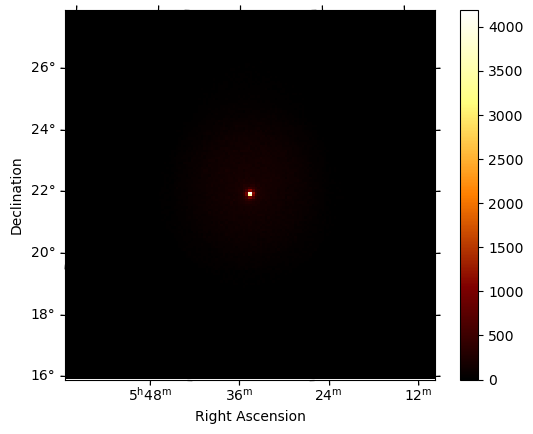

In [3]:
source = 'Crab'
path = '/home/vault/caph/mppi062h/repositories/HESS_3Dbkg_syserror/2-error_in_dataset'
path_crab = '/home/hpc/caph/mppi045h/3D_analysis/N_parameters_in_L/nuisance_summary/Crab'


dataset_load = MapDataset.read(f'{path}/{source}/stacked.fits')
dataset_load = dataset_load.downsample(4)
models = Models.read(f"{path_crab}/standard_model.yml")
model_spectrum  = PowerLawSpectralModel(
    index=2.3,
    amplitude="1e-12 TeV-1 cm-2 s-1",    )
source_model = SkyModel(spatial_model = models['main source'].spatial_model ,
                       spectral_model = model_spectrum,
                       name = "Source")    
models = Models(source_model)

bkg_model = FoVBackgroundModel(dataset_name=dataset_load.name)
bkg_model.parameters['tilt'].frozen  = False
models.append(bkg_model)
dataset_load.models = models

dataset_asimov = dataset_load.copy()
dataset_asimov.counts = dataset_load.npred()
models = Models(source_model.copy())
bkg_model = FoVBackgroundModel(dataset_name=dataset_asimov.name)
bkg_model.parameters['tilt'].frozen  = False
models.append(bkg_model)
dataset_asimov.models = models

    
dataset_load.counts.sum_over_axes().plot(add_cbar=1)
binsize = dataset_load.geoms["geom"].width[1] / dataset_load.geoms["geom"].data_shape[1]
print(
    "spatial binsize = ",
    binsize
)

print(dataset_load)

## Single Cases

In [4]:
factors = np.array([0.10])
sigma  =0.1
rnd = False
sys = sys_dataset(dataset_asimov, factors[0], rnd)
dataset_input = sys.create_dataset()


In [5]:

for i, factor in enumerate(factors):
    print(i, factor)
    sys = sys_dataset(dataset_asimov, factor, rnd)
    dataset = sys.create_dataset()
    datasets = Datasets(dataset)
    
    dataset_N = sys.create_dataset_N()
    
    sigma_a = 0.1
    penalising_covmatrix = [[1/sigma_a**2]]
    penalising_invcovmatrix =  penalising_covmatrix
    dataset_N.penalising_invcovmatrix = penalising_invcovmatrix
    datasets_N = Datasets(dataset_N)

0 0.1
4
4


In [6]:
%%time
for i, factor in enumerate(factors):
    print(i, factor)
    fit = Fit(store_trace=False)
    result = fit.run(datasets)


0 0.1
CPU times: user 3.39 s, sys: 23.4 ms, total: 3.41 s
Wall time: 3.42 s


In [8]:
%%time
for i, factor in enumerate(factors):
    fit_N = Fit(store_trace=False)
    result_N = fit_N.run(datasets_N)


CPU times: user 2.85 s, sys: 25.4 ms, total: 2.88 s
Wall time: 2.88 s


## Correlation

In [9]:
from gammapy.modeling.fit import Registry
registry= Registry()

def covariance_ (fit_compute, datasets_compute):
    #parameters = Parameters.from_stack([datasets_compute.models.parameters])
    parameters = datasets_compute.models.parameters
    parameters = parameters.free_parameters

    kwargs = fit_compute.covariance_opts.copy()
    kwargs["minuit"] = fit_compute.minuit
    backend = kwargs.pop("backend", fit_compute.backend)
    compute = registry.get("covariance", backend)

    with parameters.restore_status():
        if fit_compute.backend == "minuit":
            method = "hesse"
        else:
            method = ""
        factor_matrix, info = compute(
            parameters=parameters, function=datasets_compute.stat_sum, **kwargs
        )
        covariance = Covariance.from_factor_matrix(
            parameters=parameters, matrix=factor_matrix
        )

        #covariance = covariance.get_subcovariance(datasets_compute.models.parameters)
    return covariance

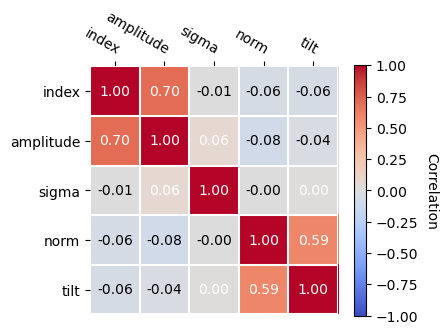

In [16]:
covariance  = covariance_(fit, dataset)
covariance.plot_correlation()


fig = plt.gcf()
fig.savefig("plots/3_corr_matrix_standard.png")

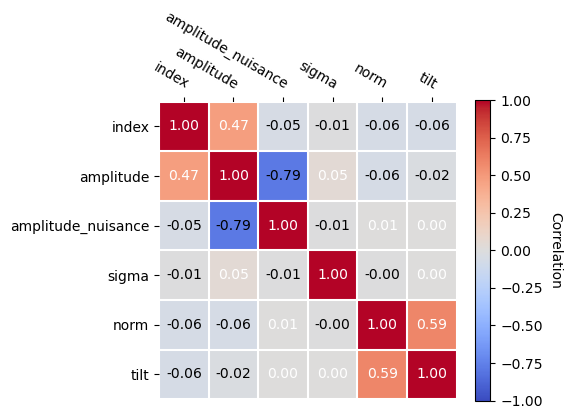

In [17]:
covariance_N  = covariance_(fit_N, dataset_N)
covariance_N.plot_correlation()


fig = plt.gcf()
fig.savefig("plots/3_corr_matrix_nuisance.png")

In [12]:
print(dataset_N.models)

DatasetModels

Component 0: SkyModel

  Name                      : SourceN
  Datasets names            : None
  Spectral model type       : PowerLawNuisanceSpectralModel
  Spatial  model type       : GaussianSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      2.301   +/-    0.06             
    amplitude                     :   1.11e-12   +/- 1.6e-13 1 / (cm2 s TeV)
    amplitude_nuisance            :      0.002   +/-    0.11             
    reference             (frozen):      1.000       TeV         
    lon_0                 (frozen):     83.631       deg         
    lat_0                 (frozen):     22.018       deg         
    sigma                         :      0.020   +/-    0.01 deg         
    e                     (frozen):      0.000                   
    phi                   (frozen):      0.000       deg         

Component 1: FoVBackgroundModel

  Name                      : dataset N-bkg
  Datasets names          